In [205]:
import mne
import numpy as np
import pandas as pd 
import os
from tqdm import tqdm
import glob
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, AffinityPropagation
from scipy.stats import mode
import time
#import dask.dataframe as daskdf

In [206]:
_dfs_list = []
for csv_filename in tqdm(glob.glob('./data/*')):
    print(csv_filename)
    _dfs_list.append(pd.read_csv(csv_filename))
df = pd.concat(_dfs_list)
df

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

./data\2019-Oct.csv


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:23<00:00, 83.05s/it]


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d
...,...,...,...,...,...,...,...,...,...
42448759,2019-10-31 23:59:58 UTC,view,2300275,2053013560530830019,electronics.camera.video,gopro,527.40,537931532,22c57267-da98-4f28-9a9c-18bb5b385193
42448760,2019-10-31 23:59:58 UTC,view,10800172,2053013554994348409,NaN,redmond,61.75,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8
42448761,2019-10-31 23:59:58 UTC,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd
42448762,2019-10-31 23:59:59 UTC,view,21407424,2053013561579406073,electronics.clocks,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204


In [207]:
#df=df.head(50000)
#making a copy for the dataframe
df = df.sample(n=50000)

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 14420153 to 13619378
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_time     50000 non-null  object 
 1   event_type     50000 non-null  object 
 2   product_id     50000 non-null  int64  
 3   category_id    50000 non-null  int64  
 4   category_code  34149 non-null  object 
 5   brand          42704 non-null  object 
 6   price          50000 non-null  float64
 7   user_id        50000 non-null  int64  
 8   user_session   50000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 3.8+ MB


In [209]:
df.describe()

,product_id,category_id,price,user_id
count,5.000000e+04,5.000000e+04,50000.000000,5.000000e+04
mean,1.053680e+07,2.057382e+18,290.287371,5.335509e+08
std,1.184810e+07,1.843698e+16,356.906486,1.854714e+07
min,1.000978e+06,2.053014e+18,0.000000,2.620338e+08
25%,1.005158e+06,2.053014e+18,66.410000,5.158826e+08
50%,5.000476e+06,2.053014e+18,164.740000,5.296401e+08
75%,1.590236e+07,2.053014e+18,358.260000,5.516878e+08
max,6.050000e+07,2.175420e+18,2574.040000,5.662723e+08


In [210]:
df.count()

event_time       50000
event_type       50000
product_id       50000
category_id      50000
category_code    34149
brand            42704
price            50000
user_id          50000
user_session     50000
dtype: int64

In [211]:
num_users = df['user_id'].nunique()
num_products = df['product_id'].nunique()
num_categories = df['category_id'].nunique()
num_category_code = df['category_code'].nunique()
num_brands = df['brand'].nunique()
print('Total number of users: ',num_users)
print('Total number of products: ', num_products)
print('Total number of categories: ', num_categories)
print('Total number of taxonomies: ', num_category_code)
print('Total number of brands: ', num_brands)

Total number of users:  47676
Total number of products:  18303
Total number of categories:  553
Total number of taxonomies:  124
Total number of brands:  1530


In [212]:
def datatypescheck(df):
    numerical_feature= [feature for feature in df.columns if df[feature].dtypes != 'O']
    discrete_feature=[feature for feature in numerical_feature if df[feature].dtypes == 'int64']
    continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
    categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
    print("Numerical Features Count {}".format(len(numerical_feature)))
    print("Discrete feature Count {}".format(len(discrete_feature)))
    print("Continuous feature Count {}".format(len(continuous_feature)))
    print("Categorical feature Count {}".format(len(categorical_feature)))
    print("Numerical features:",numerical_feature)
    print("discrete_features:",discrete_feature)
    print("continuous_features:",continuous_feature)
    print("categorical_features:",categorical_feature)
    return numerical_feature,discrete_feature,continuous_feature,categorical_feature

In [213]:
numerical_feature,discrete_feature,continuous_feature,categorical_feature=datatypescheck(df)

Numerical Features Count 4
Discrete feature Count 3
Continuous feature Count 1
Categorical feature Count 5
Numerical features: ['product_id', 'category_id', 'price', 'user_id']
discrete_features: ['product_id', 'category_id', 'user_id']
continuous_features: ['price']
categorical_features: ['event_time', 'event_type', 'category_code', 'brand', 'user_session']


### Handling Missing Value

In [214]:
#Function to analyse missing values in the dataset
def missing_values(df):
    missing_results = round(df.isnull().sum()/len(df)*100,2)
    print(missing_results)
    print("Average null values in the dataset: %4.2f"%missing_results.mean()," %")

In [215]:
missing_values(df)

event_time        0.00
event_type        0.00
product_id        0.00
category_id       0.00
category_code    31.70
brand            14.59
price             0.00
user_id           0.00
user_session      0.00
dtype: float64
Average null values in the dataset: 5.14  %


In [216]:
def handling_nullvalues(df):
    
    #list of null value columns
    null_cols = list(df.columns[df.isna().any()])
    
    #iterating through the cols to replace the null value with the mode
    for col in null_cols:
        mode=df[col].value_counts().index[0]
        df[col].fillna(mode,inplace=True) #df[col] = df[col].fillna("not available")
    return df

In [217]:
handling_nullvalues(df)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
14420153,2019-10-12 03:24:17 UTC,view,3601250,2053013563810775923,appliances.kitchen.washer,samsung,347.27,559340394,f25922a8-1778-49e8-920d-a709a7707fcc
42167570,2019-10-31 16:35:21 UTC,view,22100072,2053013561302581993,electronics.smartphone,envision,130.99,566181687,e54eb766-1622-4b57-9b57-0adefef8ca75
660747,2019-10-01 12:53:17 UTC,view,1005067,2053013555631882655,electronics.smartphone,samsung,1209.53,553823694,e595d38e-d074-40d6-b435-fee7322c9a8a
11357893,2019-10-09 17:32:10 UTC,view,2402969,2053013563743667055,appliances.kitchen.hood,haier,87.49,516130860,674fbf16-1bc9-493d-aa9f-d7426bbf8e2e
11288532,2019-10-09 16:45:43 UTC,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,141.55,514824063,7b3dc497-56d0-4c18-8abd-4e1d3f6a21b7
...,...,...,...,...,...,...,...,...,...
4479439,2019-10-04 14:22:49 UTC,view,1004426,2053013555631882655,electronics.smartphone,samsung,217.04,543306933,a581cb76-6e7e-455f-8edc-fc3f7967b4e8
6843761,2019-10-06 10:02:41 UTC,view,1802005,2053013554415534427,electronics.video.tv,lg,459.78,515357876,cf58deeb-77aa-450f-9141-6504f174645d
25133616,2019-10-19 06:11:36 UTC,view,1005217,2053013555631882655,electronics.smartphone,xiaomi,158.31,529017412,e8920612-34e2-44b1-889d-87f5a96dcd8a
15099627,2019-10-12 11:59:35 UTC,view,5700384,2053013553970938175,auto.accessories.player,pioneer,131.28,526881981,ca742b2e-9cf4-4d59-bc5c-5e5a77975c83


In [218]:
missing_values(df)

event_time       0.0
event_type       0.0
product_id       0.0
category_id      0.0
category_code    0.0
brand            0.0
price            0.0
user_id          0.0
user_session     0.0
dtype: float64
Average null values in the dataset: 0.00  %


### Remove duplicates

In [219]:
#remove duplicates
df.drop_duplicates(inplace=True)

### Handling Outliers

C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


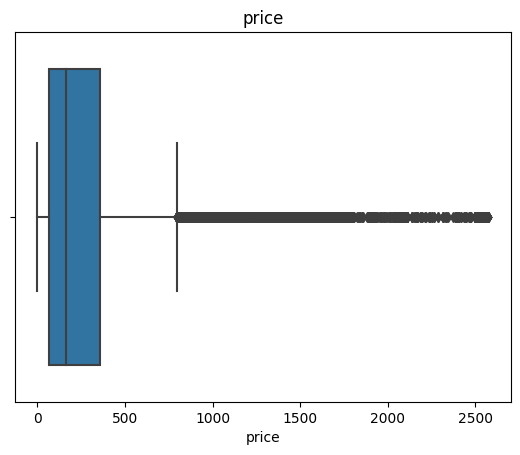

<Figure size 1500x1500 with 0 Axes>

In [220]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [221]:
def removeoutlier(df,variable):
    IQR=df[variable].quantile(0.75)-df[variable].quantile(0.25)
    lower_bridge=df[variable].quantile(0.25)-(IQR*1.5)
    upper_bridge=df[variable].quantile(0.75)+(IQR*1.5)
    print(lower_bridge, upper_bridge)
    df.loc[df[variable]>=upper_bridge,variable]=upper_bridge
    df.loc[df[variable]<=lower_bridge,variable]=lower_bridge

In [222]:
for feature in continuous_feature:
    print(feature)
    removeoutlier(df,feature)

price
-371.365 796.0350000000001


C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Dedu\anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


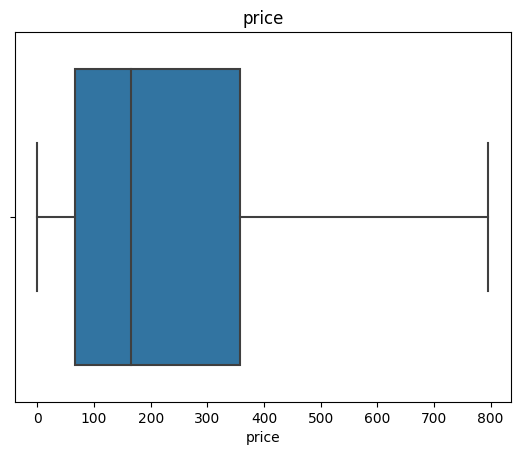

<Figure size 1500x1500 with 0 Axes>

In [223]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

### Handling Skweness for data

In [224]:
# Calculate skewness for each numerical column
for i in continuous_feature:
    skewness = df[i].skew()
    # Print the skewness values
    print(i,skewness)

price 1.1627747643385113


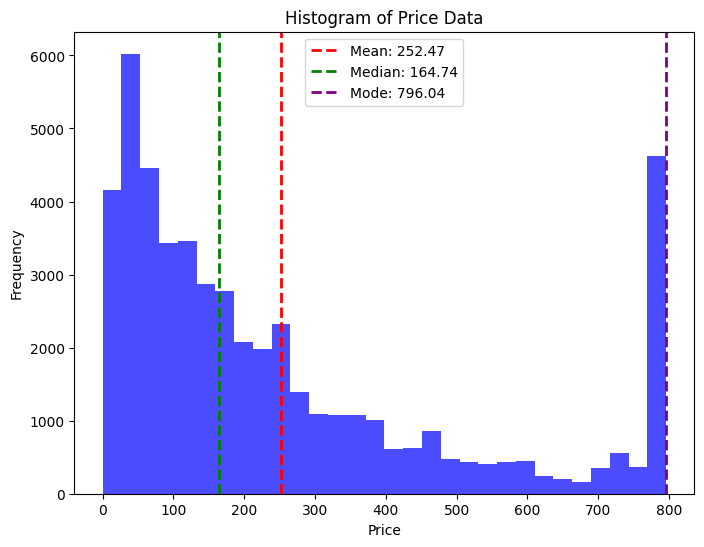

In [225]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with the 'price' column
price_data = df['price']

# Create a histogram to visualize the distribution
plt.figure(figsize=(8, 6))
plt.hist(price_data, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Price Data')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Calculate mean, median, and mode
mean_price = price_data.mean()
median_price = price_data.median()
mode_price = price_data.mode().iloc[0]  # Handle multiple modes by taking the first one

# Add vertical lines for mean, median, and mode
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_price:.2f}')
plt.axvline(median_price, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_price:.2f}')
plt.axvline(mode_price, color='purple', linestyle='dashed', linewidth=2, label=f'Mode: {mode_price:.2f}')

# Add a legend
plt.legend()

plt.show()


In [226]:
# Use the optimal lambda value for the transformation
df['price'] = np.sqrt(df['price'])

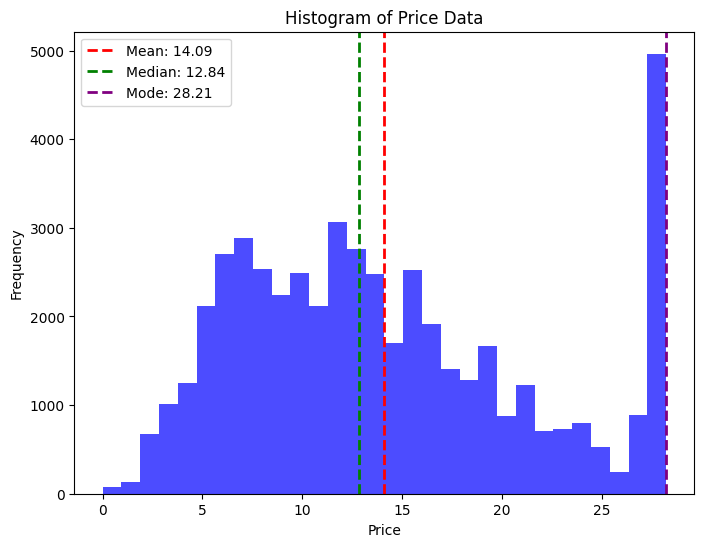

In [227]:
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with the 'price' column
price_data = df['price']

# Create a histogram to visualize the distribution
plt.figure(figsize=(8, 6))
plt.hist(price_data, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Price Data')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Calculate mean, median, and mode
mean_price = price_data.mean()
median_price = price_data.median()
mode_price = price_data.mode().iloc[0]  # Handle multiple modes by taking the first one

# Add vertical lines for mean, median, and mode
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_price:.2f}')
plt.axvline(median_price, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_price:.2f}')
plt.axvline(mode_price, color='purple', linestyle='dashed', linewidth=2, label=f'Mode: {mode_price:.2f}')

# Add a legend
plt.legend()

plt.show()


### Feature Engineering

In [228]:
df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
14420153,2019-10-12 03:24:17 UTC,view,3601250,2053013563810775923,appliances.kitchen.washer,samsung,18.635182,559340394,f25922a8-1778-49e8-920d-a709a7707fcc
42167570,2019-10-31 16:35:21 UTC,view,22100072,2053013561302581993,electronics.smartphone,envision,11.445086,566181687,e54eb766-1622-4b57-9b57-0adefef8ca75
660747,2019-10-01 12:53:17 UTC,view,1005067,2053013555631882655,electronics.smartphone,samsung,28.214092,553823694,e595d38e-d074-40d6-b435-fee7322c9a8a
11357893,2019-10-09 17:32:10 UTC,view,2402969,2053013563743667055,appliances.kitchen.hood,haier,9.353609,516130860,674fbf16-1bc9-493d-aa9f-d7426bbf8e2e
11288532,2019-10-09 16:45:43 UTC,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,11.897479,514824063,7b3dc497-56d0-4c18-8abd-4e1d3f6a21b7
...,...,...,...,...,...,...,...,...,...
4479439,2019-10-04 14:22:49 UTC,view,1004426,2053013555631882655,electronics.smartphone,samsung,14.732277,543306933,a581cb76-6e7e-455f-8edc-fc3f7967b4e8
6843761,2019-10-06 10:02:41 UTC,view,1802005,2053013554415534427,electronics.video.tv,lg,21.442481,515357876,cf58deeb-77aa-450f-9141-6504f174645d
25133616,2019-10-19 06:11:36 UTC,view,1005217,2053013555631882655,electronics.smartphone,xiaomi,12.582130,529017412,e8920612-34e2-44b1-889d-87f5a96dcd8a
15099627,2019-10-12 11:59:35 UTC,view,5700384,2053013553970938175,auto.accessories.player,pioneer,11.457748,526881981,ca742b2e-9cf4-4d59-bc5c-5e5a77975c83


In [229]:
def generate_new_features(df):
    
    df[['main_category', 'sub_category']] = df['category_code'].str.split('.', n=1, expand=True)
    
    # Convert 'event_date' to a pandas datetime object (if it's not already)
    df['event_time'] = pd.to_datetime(df['event_time'])

    # Extract year, month, day, and time into separate columns
    df['year'] = df['event_time'].dt.year
    df['month'] = df['event_time'].dt.month
    df['day'] = df['event_time'].dt.day
    df['time'] = df['event_time'].dt.strftime('%H:%M:%S')  # Extract time as HH:MM:SS format
    df['weekday'] = df['event_time'].dt.strftime('%A')
 
    df[['month','year','weekday','main_category','sub_category']] = df[['month','year','weekday','main_category','sub_category']]
    
    #generating new feature explaining the day time during which the event happened
    '''Like time ranges are assigned with the below labels as follows
       00:00am to 6:00am  -  early morning
       6:00 am to 12:00pm - morning
       12:00pm to 18:00pm - afternoon
       18:00pm to 21:00pm - evening
       21:00pm to 23:59:59pm - night
    '''
    df['time'] = pd.to_datetime(df['event_time'].dt.strftime('%H:%M:%S'))
    
    bins = [pd.to_datetime('00:00:00'), pd.to_datetime('4:00:00'), pd.to_datetime('07:00:00'),
            pd.to_datetime('12:00:00'), pd.to_datetime('16:00:00'),
            pd.to_datetime('20:00:00'), pd.to_datetime('23:59:59')]
    
    labels = ['midnight', 'early morning', 'morning', 'afternoon', 'evening', 'night']
    
    df['timing'] = pd.cut(df['time'], bins=bins, labels=labels, right=False)
    
    df.drop(['time'], axis=1, inplace=True)
    # If you want to drop the original 'event_date' column:
    df.drop('event_time', axis=1, inplace=True)
    
    
    return df


In [230]:
#generate new features
df = generate_new_features(df)
df

C:\Users\Dedu\AppData\Local\Temp\ipykernel_12704\16816785.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['event_time'].dt.strftime('%H:%M:%S'))


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,sub_category,year,month,day,weekday,timing
14420153,view,3601250,2053013563810775923,appliances.kitchen.washer,samsung,18.635182,559340394,f25922a8-1778-49e8-920d-a709a7707fcc,appliances,kitchen.washer,2019,10,12,Saturday,midnight
42167570,view,22100072,2053013561302581993,electronics.smartphone,envision,11.445086,566181687,e54eb766-1622-4b57-9b57-0adefef8ca75,electronics,smartphone,2019,10,31,Thursday,evening
660747,view,1005067,2053013555631882655,electronics.smartphone,samsung,28.214092,553823694,e595d38e-d074-40d6-b435-fee7322c9a8a,electronics,smartphone,2019,10,1,Tuesday,afternoon
11357893,view,2402969,2053013563743667055,appliances.kitchen.hood,haier,9.353609,516130860,674fbf16-1bc9-493d-aa9f-d7426bbf8e2e,appliances,kitchen.hood,2019,10,9,Wednesday,evening
11288532,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,11.897479,514824063,7b3dc497-56d0-4c18-8abd-4e1d3f6a21b7,auto,accessories.videoregister,2019,10,9,Wednesday,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4479439,view,1004426,2053013555631882655,electronics.smartphone,samsung,14.732277,543306933,a581cb76-6e7e-455f-8edc-fc3f7967b4e8,electronics,smartphone,2019,10,4,Friday,afternoon
6843761,view,1802005,2053013554415534427,electronics.video.tv,lg,21.442481,515357876,cf58deeb-77aa-450f-9141-6504f174645d,electronics,video.tv,2019,10,6,Sunday,morning
25133616,view,1005217,2053013555631882655,electronics.smartphone,xiaomi,12.582130,529017412,e8920612-34e2-44b1-889d-87f5a96dcd8a,electronics,smartphone,2019,10,19,Saturday,early morning
15099627,view,5700384,2053013553970938175,auto.accessories.player,pioneer,11.457748,526881981,ca742b2e-9cf4-4d59-bc5c-5e5a77975c83,auto,accessories.player,2019,10,12,Saturday,morning


In [231]:
numerical_feature,discrete_feature,continuous_feature,categorical_feature=datatypescheck(df)

Numerical Features Count 8
Discrete feature Count 3
Continuous feature Count 5
Categorical feature Count 7
Numerical features: ['product_id', 'category_id', 'price', 'user_id', 'year', 'month', 'day', 'timing']
discrete_features: ['product_id', 'category_id', 'user_id']
continuous_features: ['price', 'year', 'month', 'day', 'timing']
categorical_features: ['event_type', 'category_code', 'brand', 'user_session', 'main_category', 'sub_category', 'weekday']


### Analysing Unique Values

In [232]:
print(categorical_feature)

['event_type', 'category_code', 'brand', 'user_session', 'main_category', 'sub_category', 'weekday']


In [233]:
def get_uniques(df):
    
    #a dictionary to hold the unique_values
    unique_results = {col: (df[col].nunique(), df[col].unique().tolist()) for col in categorical_feature}
    for key,value in unique_results.items():
        print(key,": ",value[0])
    #printing category values if less than 10
    print("\nCategory values:")
    for key,value in unique_results.items():
        if value[0] < 20:
            print(key,": ",value[1])
    

In [234]:
#display unique values
get_uniques(df)

event_type :  3
category_code :  124
brand :  1530
user_session :  49581
main_category :  13
sub_category :  124
weekday :  7

Category values:
event_type :  ['view', 'purchase', 'cart']
main_category :  ['appliances', 'electronics', 'auto', 'computers', 'furniture', 'apparel', 'construction', 'kids', 'accessories', 'sport', 'country_yard', 'medicine', 'stationery']
weekday :  ['Saturday', 'Thursday', 'Tuesday', 'Wednesday', 'Sunday', 'Monday', 'Friday']


In [235]:
df

,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,main_category,sub_category,year,month,day,weekday,timing
14420153,view,3601250,2053013563810775923,appliances.kitchen.washer,samsung,18.635182,559340394,f25922a8-1778-49e8-920d-a709a7707fcc,appliances,kitchen.washer,2019,10,12,Saturday,midnight
42167570,view,22100072,2053013561302581993,electronics.smartphone,envision,11.445086,566181687,e54eb766-1622-4b57-9b57-0adefef8ca75,electronics,smartphone,2019,10,31,Thursday,evening
660747,view,1005067,2053013555631882655,electronics.smartphone,samsung,28.214092,553823694,e595d38e-d074-40d6-b435-fee7322c9a8a,electronics,smartphone,2019,10,1,Tuesday,afternoon
11357893,view,2402969,2053013563743667055,appliances.kitchen.hood,haier,9.353609,516130860,674fbf16-1bc9-493d-aa9f-d7426bbf8e2e,appliances,kitchen.hood,2019,10,9,Wednesday,evening
11288532,view,4700419,2053013560899928785,auto.accessories.videoregister,sho-me,11.897479,514824063,7b3dc497-56d0-4c18-8abd-4e1d3f6a21b7,auto,accessories.videoregister,2019,10,9,Wednesday,evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4479439,view,1004426,2053013555631882655,electronics.smartphone,samsung,14.732277,543306933,a581cb76-6e7e-455f-8edc-fc3f7967b4e8,electronics,smartphone,2019,10,4,Friday,afternoon
6843761,view,1802005,2053013554415534427,electronics.video.tv,lg,21.442481,515357876,cf58deeb-77aa-450f-9141-6504f174645d,electronics,video.tv,2019,10,6,Sunday,morning
25133616,view,1005217,2053013555631882655,electronics.smartphone,xiaomi,12.582130,529017412,e8920612-34e2-44b1-889d-87f5a96dcd8a,electronics,smartphone,2019,10,19,Saturday,early morning
15099627,view,5700384,2053013553970938175,auto.accessories.player,pioneer,11.457748,526881981,ca742b2e-9cf4-4d59-bc5c-5e5a77975c83,auto,accessories.player,2019,10,12,Saturday,morning


### save file 

In [237]:
# Specify the file path for the CSV file
csv_file_path = 'preprocesseddata.csv'

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)